### Investigating Spell-Checking Usage in Data Pre-Processing Phase for Topic Modeling on Hotel Reviews

#### What makes hotels good or bad? Is spell checking on reviews something to take into consideration? Analysis using BERTopic






### Initial Analysis


In [1]:
# Imports data from a csv from Kaggle
import pandas as pd

df = pd.read_csv('tripadvisor_hotel_reviews.csv')

In [2]:
df

Review  Rating
0      nice hotel expensive parking got good deal sta...       4
1      ok nothing special charge diamond member hilto...       2
2      nice rooms not 4* experience hotel monaco seat...       3
3      unique, great stay, wonderful time hotel monac...       5
4      great stay great stay, went seahawk game aweso...       5
...                                                  ...     ...
20486  best kept secret 3rd time staying charm, not 5...       5
20487  great location price view hotel great quick pl...       4
20488  ok just looks nice modern outside, desk staff ...       2
20489  hotel theft ruined vacation hotel opened sept ...       1
20490  people talking, ca n't believe excellent ratin...       2

[20491 rows x 2 columns]

In [3]:
# Checking size of the dataset 
print('There are',df.shape[0],'reviews on this dataset')

There are 20491 reviews on this dataset


In [4]:
# Shows distributions of data 

df["Rating"].value_counts()

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

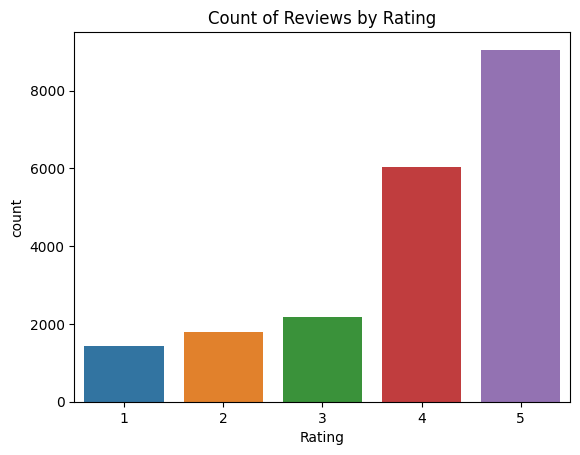

In [5]:
# Plots distributions of data 

import matplotlib.pyplot as plt
from seaborn import countplot

countplot(data=df,x="Rating")
plt.title('Count of Reviews by Rating');

From the plot above, it's possible to confirm that our data is left skewed, since there are way more 4 and 5 star ratings than 1,2 and 3 star ratings.

In [316]:
# Pre Analysis - Most common tokens in all the reviews together (not review by review) - Top 15

import itertools
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

tokens = [word_tokenize(text) for text in df['Review']]
merged_tokens = list(itertools.chain(*tokens))
fdist=FreqDist(merged_tokens)
print("Top 15 most common tokens in all the reviews:")
fdist.most_common(15)



Top 15 most common tokens in all the reviews:


[(',', 246646),
 ('hotel', 48811),
 ('room', 34270),
 ('not', 31542),
 ('great', 21090),
 ("n't", 18987),
 ('good', 16966),
 ('staff', 16197),
 ('stay', 15142),
 ('did', 13895),
 ('just', 12600),
 ('nice', 12403),
 ('rooms', 12003),
 ('no', 11609),
 ('location', 11013)]

After a pre-analysis of the data, there's the need of doing some pre-processing. The main problems that were found are the presence of:

- Needless punctuation (the comma is the most used "word" in the whole dataset, pretty expectable, since it's part of the basic writting rules.);
- Stop words (words that are present in any language like articles, prepositions,..etc.- For example "just", in this case); 
- Some extra "Stop words" like hotel, room and stay that have a very high frequency but don't add any value to the analysis;

Additionally, some other problems might be encounter, such as, equal words with different letter case, incorrect spelling, etc. Therefore, some pre-processing will be applied.

### Pre-Processment of Data Experiments



In [7]:
# Setting a smaller dataset for an initial analysis 

df_small = df[:100]

In [8]:
# Set data - For the analysis the small dataset will be used, but once the analysis is complete, full data set will be used to do the main
# analysis.

data = df_small


In the labs, SpaCy was used to perform this task. 

First experience: Use NLTK and another package used for spelling correction, TextBlob.

Steps:
\
Lowercasing\
Remove non-alphanumeric characters\
Spelling Correction\
Tokenization\
Stopwords Removal\
Lemmatization

### Pre-process data with Spell Checking (NLTK + Spell Checking)

In [9]:
# Pre-processing with NLTK
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag



def pre_processing(text):

    # Lowercasing 
    text_lower = text.lower()
    # Remove all non-alphanumeric characters from string, preserving whitespace 
    text_clean = re.sub(r'[^\w\s]', '', text_lower)
    # Tokenize
    tokens = word_tokenize(text_clean)
    # Stop words Removal 
    en_stopwords = stopwords.words('english')
    tokens_stopwords_removal = [token for token in tokens if token not in en_stopwords]
    #Lemmatization
    wordnet = WordNetLemmatizer()

    tokens_lemma =[]
    for token, tag in pos_tag(tokens_stopwords_removal):
        pos = tag[0].lower()
        if pos in ['a', 'r', 'n', 'v']:
            pos = pos
        else:
            pos ='n'
        tokens_lemma.append(wordnet.lemmatize(token,pos))

    # Remove extra stop words after lemmatization (hotel and room)

    tokens_extra_sw_removal = [token for token in tokens_lemma if token not in ["hotel","room","stay"]]
    
    # SpellChecking using TextBlob 
    text_spellchecked = str(TextBlob(' '.join(tokens_extra_sw_removal)).correct())
    

    return(text_spellchecked)
 


In [10]:
import time
start_time = time.time()

# Run pre_processing function that uses NLTK and text_blob function on 100 reviews 
preprocessed_reviews_nltk = [pre_processing(review) for review in data['Review']]

end_time = time.time()
running_time_nltk = end_time - start_time
print('Duration: {}'.format(running_time_nltk))
#Takes +- 2:40 seconds for 100 reviews 


Duration: 124.37385511398315


Now let's compare this pre-processing with the one done in the labs, using spaCy.

### Pre-process data without Spell Checking (spaCy)

Steps:
\
Tokenization\
Stopwords Removal\
Lemmatization

In [11]:
# Pre-processing in spaCy 

# Pre-processing used in the labs using spacy. Uses tokenisation, stop word removal, and lemmatisation
import spacy
nlp = spacy.load("en_core_web_sm", exclude=['parser', 'ner'])
def preprocess(text):
    return [token.lemma_ for token in nlp(text) if (not token.is_stop and token.is_alpha and token.lemma_ not in ["hotel","room","stay"])]

In [12]:
import time
start_time = time.time()


preprocessed_reviews_spacy = [preprocess(review) for review in data['Review']]


end_time = time.time()
running_time_spacy = end_time - start_time
print('Duration: {}'.format(running_time_spacy))
#Takes +- 6/7 seconds for 100 reviews 

Duration: 0.8111832141876221


Now let's compare the two methods

In [13]:
print("spaCy processing is",(round(running_time_nltk/running_time_spacy)),'faster than NLTK')

spaCy processing is 153 faster than NLTK


In [14]:
preprocessed_reviews_nltk[4]

'great great go seahawk game awesome downfall view build it complain huge staff helpful book webster seahawk package charge park get voucher taxi problem taxi driver it want accept voucher barely speak english funny thing speak arabic call start make comment girlfriend cell phone muddy take second realize say fact speak language face priceless as tell say large city tell head footman issue call cab company promptly answer it apologize offer pay taxi buck 2 mile stadium game plan taxi return go human great walk it mind right christmas wonderful light homeless show away build entrance leave police presence greatest area stadium activity 7 block pike street waterfront great coffee shop way maintained for awesome wine taste available even best dog take st bernhard time family safe locate service desk bathroom huge jet tub huge funny house keep walked girlfriend get dress it hear knock turn service scream girlfriend scream hit floor laughing start talk spanish work place recommend price che

In [15]:
' '.join(preprocessed_reviews_spacy[4])

'great great go seahawk game awesome downfall view building complain huge staff helpful book website seahawk package charge parking get voucher taxi problem taxi driver want accept voucher barely speak english funny thing speak arabic call start make comment girlfriend cell phone buddy take second realize say fact speak language face priceless ass tell say large city tell head doorman issue call cab company promply answer apologize offer pay taxi buck mile stadium game plan taxi return go humpin great walk mind right christmas wonderful light homeless stow away build entrance leave police presence great area stadium activity block pike street waterfront great coffee shop way mantaine foyer awesome wine taste available evening good dog take st bernard time family safe locate service desk bathroom huge jetted tub huge funny house keeping walk girlfriend get dress hear knock turn service scream girlfriend scream hit floor laugh start talk spanish work place recommend price check online de

At a first impression, by observing some reviews of the two methods, it's possible to conclude that both are very similar. However, spaCy review is not doing any spell checking.\
\
Example from 5th review:\
NLTK: "...great coffee shop way hotel maintained for awesome wine taste available ..."\
spaCy: "...great coffee shop way hotel mantaine foyer awesome wine taste available..."\
original: "...great coffee shops way, hotel mantained foyer awesome, wine tasting available..."

The word "maintained" was clearly misspelled in the original review. spaCy pre-processing function can't handle spell checking, which could be a serious problem in this case, since these reviews are written by thousands of users without any kind of verification before submission. If this dataset was, for example, news from a journal, spell checking wouldn't be something so important to have in consideration, since all text is carefully checked before being released.


Therefore, a third method for pre-processing will be computed, that is composed by spaCy pre-processing and spell checking.

### Pre-processed data with Spell Checking (spaCy + Spell Checking)

Steps:
\
Tokenization\
Stopwords Removal\
Lemmatization\
Spelling Correction

In [16]:
# Pre-processing in spaCy + Spell Checking
from textblob import TextBlob

def preprocess_spacy_spellcheck(text):
    tokens = [token.lemma_ for token in nlp(text) if (not token.is_stop and token.is_alpha and token.lemma_ not in ["hotel","room","stay"])]
    text_spellchecked = str(TextBlob(' '.join(tokens)).correct())

    return text_spellchecked

In [17]:
start_time = time.time()


preprocessed_reviews_spacy_spellcheck = [preprocess_spacy_spellcheck(review) for review in data['Review']]


end_time = time.time()
running_time_final = end_time - start_time
print('Duration: {}'.format(running_time_final))
#Takes +- 90 seconds for 100 reviews 

Duration: 73.85506343841553


In [18]:
preprocessed_reviews_spacy_spellcheck[4]

'great great go seahawk game awesome downfall view building complain huge staff helpful book webster seahawk package charge parking get voucher taxi problem taxi driver want accept voucher barely speak english funny thing speak arabic call start make comment girlfriend cell phone muddy take second realize say fact speak language face priceless ass tell say large city tell head footman issue call cab company promptly answer apologize offer pay taxi buck mile stadium game plan taxi return go human great walk mind right christmas wonderful light homeless show away build entrance leave police presence great area stadium activity block pike street waterfront great coffee shop way maintain for awesome wine taste available evening good dog take st bernhard time family safe locate service desk bathroom huge petted tub huge funny house keeping walk girlfriend get dress hear knock turn service scream girlfriend scream hit floor laugh start talk spanish work place recommend price check online dea

In [19]:
print("spaCy processing is still",(round(running_time_final/running_time_spacy)),'faster than spaCy + Spell Checking.')

spaCy processing is still 91 faster than spaCy + Spell Checking.


Spell Checking increased the processment time on Spacy pre-processing by all amost 100 times on very small dataset of 100 reviews. Is Spell Checking a crutial step to perform topic analysis? Let's dive in 

# Topic Analysis

#### Case 1 - Without spell checking

In [20]:
# Set data as the full data set
data = df


In [21]:
import time
start_time = time.time()


preprocessed_reviews_spacy = [preprocess(review) for review in data['Review']]


end_time = time.time()
running_time_spacy = end_time - start_time
print('Duration: {}'.format(running_time_spacy))
#Takes +- 3.10mn  for all reviews 

Duration: 132.69538950920105


In [22]:
preprocessed_reviews_spacy_text = [' '.join(list_tokens) for list_tokens in preprocessed_reviews_spacy]
data.insert(2,"PreProcess_Reviews_No_SpellCheck",preprocessed_reviews_spacy_text)

In [23]:
data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                    PreProcess_Reviews_No_SpellCheck  
0  nice expensive parking get good deal anniversa...  
1  ok special charge diamond member hilton decide...  
2  nice experience monaco seattle good large bath...  
3  unique great wonderful time monaco location ex...  
4  great great go seahawk game awesome downfall v...

In [282]:
# Pre Analysis - Most common words in all the reviews together (not review by review) - Top 15

import itertools
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

tokens_no_spell_check = [word_tokenize(text) for text in data['PreProcess_Reviews_No_SpellCheck']]
merged_tokens_no_spell_check = list(itertools.chain(*tokens_no_spell_check))
fdist=FreqDist(merged_tokens_no_spell_check)
fdist.most_common(15)

[('good', 21519),
 ('great', 21283),
 ('staff', 16376),
 ('night', 14168),
 ('day', 13035),
 ('nice', 12970),
 ('time', 12197),
 ('location', 11254),
 ('service', 10682),
 ('clean', 10609),
 ('restaurant', 10221),
 ('beach', 10161),
 ('breakfast', 9707),
 ('place', 9704),
 ('walk', 9572)]

#### Word Cloud

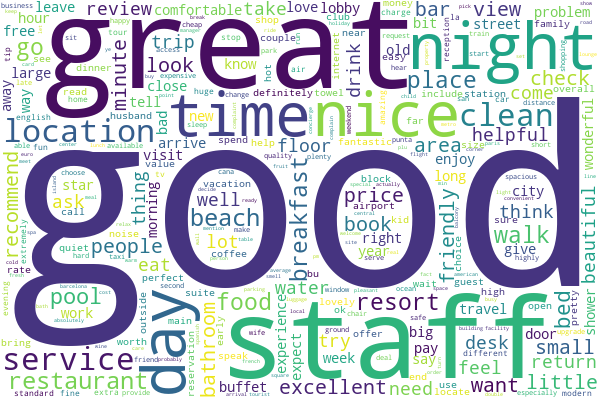

In [25]:
text_forwordcloud=' '.join(data['PreProcess_Reviews_No_SpellCheck'])
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=300, contour_width=3,contour_color='steelblue', width=600, 
height=400, scale=1, max_font_size=400, collocations=False)
# Generate a word cloud
wordcloud.generate(text_forwordcloud)
# Visualize the word cloud
wordcloud.to_image()


The word cloud is presented above, showing the most frequent tokens in the dataset after pre-processing. Tokens
with the largest font size are the most frequent.


The word cloud highlights the fact that this dataset is imbalanced, and therefore, positive correlated tokens are way more common than the negative ones. From a business prespective, this may be a problem for the analysis, since noticing negative points will add way more value to the business than focusing on the positive ones, in order to retain more clients and avoid bad reputation.

Let's show three WordClouds for a better visualization by splliting the data into positive, neutral and negative reviews.
Positive reviews will be ratings of 4 and 5, Neutral reviews with rating of 3 and Negative reviews with ratings of 1 and 2.

In [26]:
label_dict = {1 : 'negative', 2 : 'negative', 3: 'neutral', 4 : 'positive', 5: 'positive'}
Label = data["Rating"].map(label_dict)
data.insert(3,"Label",Label)

In [27]:
data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                    PreProcess_Reviews_No_SpellCheck     Label  
0  nice expensive parking get good deal anniversa...  positive  
1  ok special charge diamond member hilton decide...  negative  
2  nice experience monaco seattle good large bath...   neutral  
3  unique great wonderful time monaco location ex...  positive  
4  great great go seahawk game awesome downfall v...  positive

WordCloud for Reviews by Label

In [28]:
# Creates text vectors for each type of review (positive, neutral and negative) to be used as input for the wordcloud

positive_data = data[data.Label == 'positive']
text_pos_forwordcloud=' '.join(positive_data['PreProcess_Reviews_No_SpellCheck'])

neutral_data = data[data.Label == 'neutral']
text_neutral_forwordcloud=' '.join(neutral_data['PreProcess_Reviews_No_SpellCheck'])

negative_data = data[data.Label == 'negative']
text_neg_forwordcloud=' '.join(negative_data['PreProcess_Reviews_No_SpellCheck'])

list_pos_neut_neg = list([text_pos_forwordcloud, text_neutral_forwordcloud, text_neg_forwordcloud])

list_labels_pos_neut_neg = ["Positive", "Neutral", "Negative"]



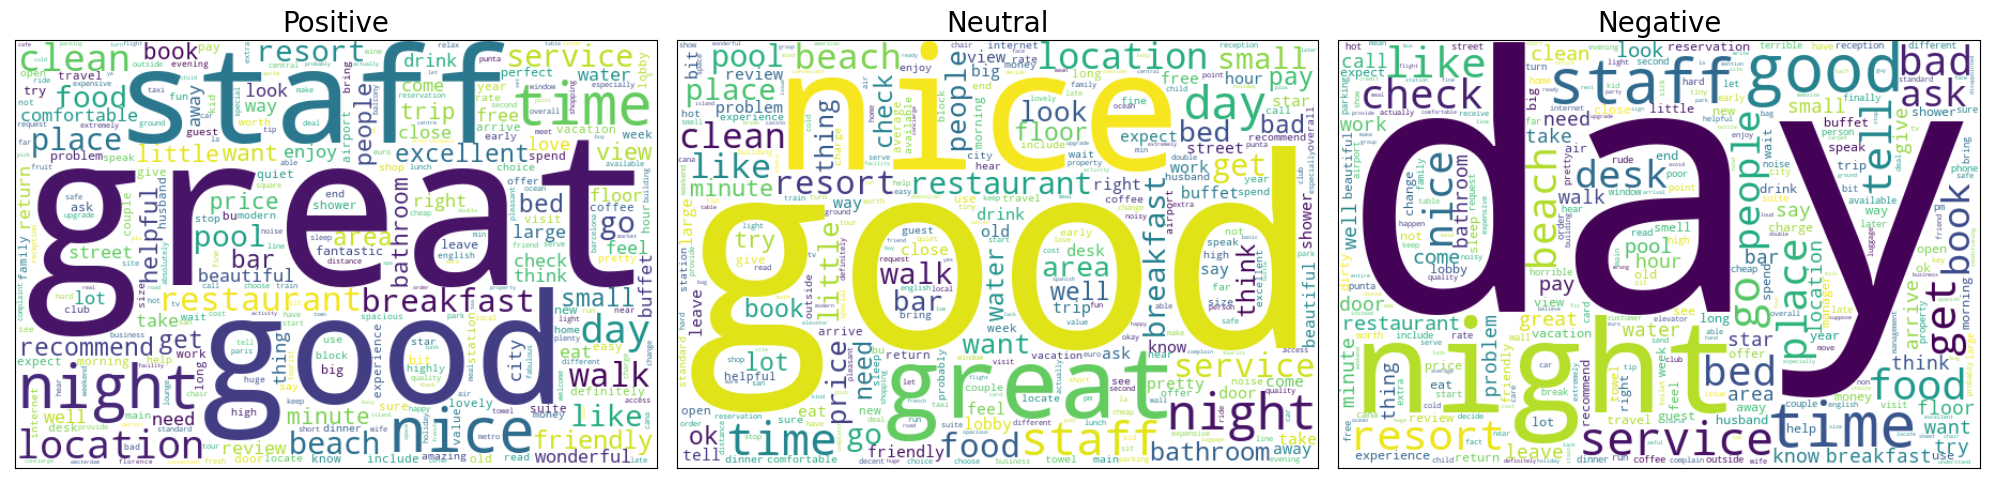

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,40))
for i in range(3):
    plt.subplot(1,3,i+1)    

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=300, contour_width=3,contour_color='steelblue', width=600, 
    height=400, scale=1, stopwords=["hotel","room","stay"], max_font_size=400, collocations=False)
    # Generate a word cloud
    wordcloud.generate(list_pos_neut_neg[i])
    # Visualize the word cloud
    #wordcloud.to_image()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(list_labels_pos_neut_neg[i], size=20)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.savefig(fname="img\WordClouds", bbox_inches='tight')
plt.show()

### Topic Analysis

Even though the main goal of this research is to apply BERTopic as the algorithm for topic analysis, as a baseline approach, LDA (Latent Dirichlet allocation) will be applied.

#### LDA

Contrary to BERTopic, LDA requires an user input of the k number of topics that data will be clustered into.
The model was set with 10 topics (k = 10) and using the default values for all the other parameters.

In [299]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [300]:
PreProcess_Reviews_No_SpellCheck_tk = [token.split() for token in data['PreProcess_Reviews_No_SpellCheck']]

In [301]:
# LDA applied in labs 
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import importlib
from imp import reload

# Create a dictionary representation of the documents.
dictionary = Dictionary(PreProcess_Reviews_No_SpellCheck_tk)

corpus = [dictionary.doc2bow(doc) for doc in PreProcess_Reviews_No_SpellCheck_tk]

# Set training parameters.
num_topics = 10

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=12345
)

In [302]:
for topic in model.show_topics():
    print('')
    print('Topic',topic[0]+1,':',topic[1])



Topic 1 : 0.014*"good" + 0.013*"walk" + 0.011*"nice" + 0.011*"breakfast" + 0.010*"night" + 0.009*"location" + 0.008*"great" + 0.007*"clean" + 0.007*"free" + 0.007*"area"

Topic 2 : 0.031*"great" + 0.026*"resort" + 0.015*"beautiful" + 0.015*"beach" + 0.014*"nice" + 0.014*"time" + 0.012*"food" + 0.012*"love" + 0.011*"pool" + 0.011*"good"

Topic 3 : 0.014*"service" + 0.012*"good" + 0.010*"restaurant" + 0.009*"area" + 0.009*"staff" + 0.008*"pool" + 0.008*"view" + 0.008*"nice" + 0.008*"great" + 0.007*"night"

Topic 4 : 0.018*"good" + 0.017*"great" + 0.012*"location" + 0.012*"staff" + 0.011*"night" + 0.010*"clean" + 0.009*"small" + 0.009*"nice" + 0.009*"bathroom" + 0.009*"bed"

Topic 5 : 0.027*"topless" + 0.011*"hollywood" + 0.010*"pen" + 0.007*"scooter" + 0.006*"motorize" + 0.006*"absence" + 0.005*"night" + 0.005*"rudest" + 0.005*"secondly" + 0.004*"biggie"

Topic 6 : 0.028*"great" + 0.022*"staff" + 0.019*"location" + 0.011*"breakfast" + 0.011*"clean" + 0.011*"night" + 0.011*"helpful" + 0.

#### Intertopic Distance Map (IDM)

In [303]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.048736  0.092317       1        1  19.225640
1      0.086473 -0.162313       2        1   4.719459
2      0.050118  0.048830       3        1   9.090467
3      0.051743  0.086123       4        1   9.413538
4     -0.265024 -0.087640       5        1   0.216503
5      0.059849  0.070958       6        1  13.221808
6      0.078312 -0.019982       7        1   7.393445
7     -0.226107  0.071628       8        1   0.916137
8      0.033472 -0.023615       9        1  10.668019
9      0.082426 -0.076306      10        1  25.134984, topic_info=        Term          Freq         Total Category  logprob  loglift
24     great  22657.000000  22657.000000  Default  30.0000  30.0000
4511  resort   9376.000000   9376.000000  Default  29.0000  29.0000
76      book   6390.000000   6390.000000  Default  28.0000  28.0000
4565   beach  10618.000000  10618.000000  Default  27.0000  27.0000
179    staff  16557.000000  16557.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
838      bar   2363.031649   7859.547590  Topic10  -5.2575   0.1791
41     night   2737.178521  14295.414757  Topic10  -5.1105  -0.2721
24     great   3045.288650  22657.409287  Topic10  -5.0038  -0.6260
179    staff   2260.409680  16557.115850  Topic10  -5.3019  -0.6104
190    thing   1939.081259   4877.995591  Topic10  -5.4552   0.4584

[847 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
9209      5  0.973740    absence
3457      2  0.906275  absolutly
3457      4  0.015625  absolutly
3457      7  0.046876  absolutly
3457      9  0.031251  absolutly
...     ...       ...        ...
3220      7  0.030665       york
3220      8  0.005411       york
3220      9  0.028861       york
3220     10  0.018038       york
5583      6  0.972488      youth

[2871 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Above there's a Intertopic Distance Map (IDM), that represents the 10 topics and the distance between them. The closer a topic is from other topic the more similar and the opposite for dissimilar topics. The size of the topic's circle represent the frequency of the topic in the corpus. Individual topics can be selected by clicking on it. The relevance metric (λ) can be adjusted as, for a larger λ there's a higher probability of the term occurring in the topic.


General:

* Topic 1 and 4 : "City Hotels"
**Includes words like: walk, nice, breakfast, location, clean, metro** which gives an impression that this topics referers to Urban Hotels, located in the center of cities or sightseeing areas.

* Topic 2 : "Resort Hotels"
**Includes words like: resort,beautiful,beach,pool,food.**

* Topic 6 : "Top Hotels/Comfortable Hotels"
**Includes words like: (great, location, walk,breakfast, clean, friendly, recommend).**

Specific:

* Topic 8 : "Complaints about Hilton Hotel in London"
**Includes words like: (london, hilton, book, executive, smoking, tell, staff)**

The output of the model is, overall, not very decisive and sometimes quite confusing. However, even though there are some really strange topics (like Topic 5), there were other topics (the ones described above) from where some conclusions could be taken.


#### BERTopic

In [35]:
data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                    PreProcess_Reviews_No_SpellCheck     Label  
0  nice expensive parking get good deal anniversa...  positive  
1  ok special charge diamond member hilton decide...  negative  
2  nice experience monaco seattle good large bath...   neutral  
3  unique great wonderful time monaco location ex...  positive  
4  great great go seahawk game awesome downfall v...  positive

In [247]:
from umap import UMAP
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1,3))

umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.2, metric='cosine', random_state=42)

topic_model_no_spellcheck = BERTopic(vectorizer_model=vectorizer_model,
                        language='english',
                        umap_model=umap_model)

In [248]:
text= data['PreProcess_Reviews_No_SpellCheck']
topics, probs = topic_model_no_spellcheck.fit_transform(text)

2023-01-14 01:20:50,715 - BERTopic - Transformed documents to Embeddings
2023-01-14 01:21:06,896 - BERTopic - Reduced dimensionality
2023-01-14 01:21:11,391 - BERTopic - Clustered reduced embeddings


In [249]:
topic_model_no_spellcheck.get_topic_info()

Topic  Count                                               Name
0      -1  10402                          -1_good_great_staff_beach
1       0    890                   0_florence_venice_italy_location
2       1    770                      1_barcelona_rambla_metro_city
3       2    747                      2_paris_metro_eiffel_location
4       3    671                    3_amsterdam_location_tram_canal
..    ...    ...                                                ...
93     92     11                 92_ubud_villa_private_ubud village
94     93     10              93_bahia_resort_course_bahia principe
95     94     10                  94_paradisus_beach_day_restaurant
96     95     10  95_chinatown_location_financial district_finan...
97     96     10      96_hollywood_renaissance_kodak_hollywood sign

[98 rows x 3 columns]

-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [250]:
topic_model_no_spellcheck.get_topic(0) # Select the most frequent topic

[('florence', 0.022433290420999678),
 ('venice', 0.006978544946351129),
 ('italy', 0.00682962174224803),
 ('location', 0.006820564825505924),
 ('walk', 0.006819490149150366),
 ('breakfast', 0.006733507402765099),
 ('duomo', 0.006272723079719323),
 ('great', 0.005935930425281128),
 ('staff', 0.0056731034873399085),
 ('train', 0.005558560441413684)]

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, the output below can be analysed, where clusters of the topics are created and it's possible to visualize how these relate to one another.

In [251]:
topic_model_no_spellcheck.visualize_hierarchy()

#### Intertopic Distance Map (IDM)

In [252]:
topic_model_no_spellcheck.visualize_topics()

The IDM is really interesting to analyse, since it's possible to see that some topics that would make sense to be closer to each other are indeed forming a "bigger" cluster containing those topics. For example, there's a group representing resort hotels, another representing city hotels and another regarding complaints.

BERTopic allows for topic reduction after training the model. The hierarchical clustering graph and the IDM might help to select an appropriate number of topics when reducing the nr_topics that were created. 

However, for this analysis, the topics will be analysed at a closer look on the next tasks and therefore, no topic reduction will be applied.

##### Optimize Labels


To try to answer the question of what makes hotels good or bad, some fine-tune of the labeling can be done. A set of potential topic labels (like good hotels or bad hotels) can be used to try to separate the ones generated by BERTopic. For that, the bart-large-mnli model will be used to find which user-defined labels best represent the BERTopic-generated labels.

bart-large-mnli: BART model pre-trained on English language (Multi-Genre Natural Language Inference (MultiNLI))\
https://huggingface.co/facebook/bart-large-mnli

In [253]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Example

In [254]:
sequence_to_classify =  " ".join([word for word, _ in topic_model_no_spellcheck.get_topic(1)])
print("sequence_to_classify:",sequence_to_classify)
# Our set of potential topic labels
candidate_labels = ['Good', 'Bad']
classifier_output=classifier(sequence_to_classify, candidate_labels)
print("Optimized Label:",classifier_output["labels"][0])

sequence_to_classify: barcelona rambla metro city location good euro great walk staff
Optimized Label: Good


Training on full set of topics generated

In [255]:
tuned_labels = dict()

for topic in topic_model_no_spellcheck.topic_labels_:
    sequence_to_classify =  " ".join([word for word, _ in topic_model_no_spellcheck.get_topic(topic)])
    # Our set of potential topic labels
    candidate_labels = ['Good', 'Bad']
    classifier_output=classifier(sequence_to_classify, candidate_labels)
    tuned_labels[topic] = classifier_output["labels"][0]


In [256]:
neg_tuned_labels = dict()
pos_tuned_labels = dict() 

for key,value in tuned_labels.items():
    if value=='Good':
        pos_tuned_labels[key]=value
    if value=='Bad':
        neg_tuned_labels[key]=value

##### What makes hotels good or bad?

In [257]:
topic_model_no_spellcheck.visualize_barchart(topics= pos_tuned_labels.keys(),title="Good Hotels - Topic Word Scores")

The great majority of topics presented above end up being very specific, representing specific places (cities/countries) or even hotels.

Examples:
-	Topic 0 (the most frequent topic) - contains “florence”,”venice”,”Italy”, etc – Could be “Hotels in Italy”.
-	Topic 1 – contains “barcelona”, “rambla”, “metro”, etc – Could be “Hotels in Barcelona”
-	Topic 31 – contains “ritz”, “ritz carlton”, etc – Could be “Ritz-Carlton Hotels “

But there are also some topics that are more general and help explaining the makes hotels “good” in this case, such as: 
-	Topic 4 – contains “location”,”staff” ,”clean”, etc – That clearly represents some of the characteristics that nice/well rated hotels have. 
-	Topic 23 – contains “beach”,”resort”,”pool”, “food”,etc – Typical characteristics of resort hotels.
-	Topic 26 – contains “bed”,”comfortable”,”bathroom”, ect – Other positive characteristics, including the bedroom.

The topics that seem to represent best what are the characteristics that makes hotels good are:
Topic 4, 23, 26, 29, 33, 37, 38, 39, 52, 53, 55, 60, 62, 63, 67, 68, 70 73, 76, 78, 82, 86, 89.

These are also shown below for a better visualization.


In [258]:
topic_model_no_spellcheck.visualize_barchart(topics= [4, 23, 26, 29, 33, 37, 38, 39, 52, 53, 55, 60, 62, 63, 67, 68, 70,73, 76, 78, 82, 86, 89],
title="Good Hotels Characteristics - Topic Word Scores")

In [259]:
topic_model_no_spellcheck.visualize_barchart(topics= neg_tuned_labels.keys(),title="Bad Hotels - Topic Word Scores")

As expected, due to the class unbalance in the dataset, there are way fewer topics representing negative aspects. It’s very interesting how the topics seem to make a lot of sense in the context of the problem. 

Examples: 
-	Topic 16 – Contains “dirty”, ”smell”, ”stain”,”bad”,etc – General characteristics of bad/low rated hotels.
-	Topic 54 – Contains “food”, “sick”, “doctor”, “resort”, “stomach” – Refers to food poisoning occurrences. A high importance aspect that should be handled since it bears on public health.
-	Topic 84 – Contains “steal”, “theft”, etc – Refers to robbery occurrences.


In [260]:
topics_per_class = topic_model_no_spellcheck.topics_per_class(text, classes=data["Label"])
topic_model_no_spellcheck.visualize_topics_per_class(topics_per_class,top_n_topics=103, normalize_frequency=True)

The graph above allows to see the normalized frequency of topics per class (Label, in this case), which is a nice way of checking whether the topic refers more to a positive, negative, or neutral review.

For example, topic 20 (“desk”,”check”, etc) and specially topic 27 (“reservation”,”charge”,”card”,”credit”) seem to be more related to negative aspects than positive (initially classified with “Good” by the model bart-large-mnli). By selecting these 2 topics on the graph it’s possible to confirm that both topics are more connected to negative reviews, focusing topic 27.

Besides topic 20 and 27, If now we select all the other “Bad Hotels” topics it’s also obvious that there’s a way higher frequency of negative reviews, compared to positive or neutral reviews.

##### Search topics

BERTopic also allows to search for topic using search terms. By using the function find_topics it's possible to find the topics that are similar to an input search_term. In the example below, I am looking for the topic that is the most closely related to the term "loudly". 

In [310]:
search_term = "loudly"

similar_topics, similarity = topic_model_no_spellcheck.find_topics(search_term, top_n=5)
print("Most similar topic to", search_term,"- Topic",similar_topics[0],":")
topic_model_no_spellcheck.get_topic(similar_topics[0])

Most similar topic to loudly - Topic 30 :


[('noise', 0.03385865666437309),
 ('noisy', 0.01610520912885169),
 ('sleep', 0.01121538669769389),
 ('hear', 0.00938678688641631),
 ('night', 0.009193694453263212),
 ('street', 0.0083888209078966),
 ('floor', 0.007447639415148755),
 ('window', 0.007220355510614615),
 ('loud', 0.006868484589765134),
 ('problem', 0.005665131133686572)]

#### Case 2 - With spell checking

The same analysis that was performed above will be done again using the pre-processed data with spell checking.

In [50]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [51]:
start_time = time.time()


preprocessed_reviews_spacy_spellcheck = [preprocess_spacy_spellcheck(review) for review in data['Review']]


end_time = time.time()
running_time_final = end_time - start_time
print('Duration: {}'.format(running_time_final))
#Takes +- 5 hours for all reviews 

Duration: 19868.053814411163


In [52]:
data.insert(3,"PreProcess_Reviews_With_SpellCheck",preprocessed_reviews_spacy_spellcheck)

In [53]:
data.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not 4* experience hotel monaco seat...       3   
3  unique, great stay, wonderful time hotel monac...       5   
4  great stay great stay, went seahawk game aweso...       5   

                    PreProcess_Reviews_No_SpellCheck  \
0  nice expensive parking get good deal anniversa...   
1  ok special charge diamond member hilton decide...   
2  nice experience monaco seattle good large bath...   
3  unique great wonderful time monaco location ex...   
4  great great go seahawk game awesome downfall v...   

                  PreProcess_Reviews_With_SpellCheck     Label  
0  nice expensive parking get good deal anniversa...  positive  
1  ok special charge diamond member hilton decide...  negative  
2  nice experience monarch seattle good large bat...   neutral  
3  unique great wonderful time monarch location e...  positive  
4  great great go seahawk game awesome downfall v...  positive

In [281]:
# Pre Analysis - Most common words in all the reviews together (not review by review) - Top 15

import itertools
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

tokens_with_spell_check = [word_tokenize(text) for text in data['PreProcess_Reviews_With_SpellCheck']]
merged_tokens_with_spell_check = list(itertools.chain(*tokens_with_spell_check))
fdist=FreqDist(merged_tokens_with_spell_check)
fdist.most_common(15)

[('good', 21614),
 ('great', 21372),
 ('staff', 16417),
 ('night', 14195),
 ('day', 13079),
 ('nice', 12991),
 ('time', 12286),
 ('location', 11283),
 ('restaurant', 10965),
 ('service', 10779),
 ('clean', 10618),
 ('place', 10581),
 ('beach', 10176),
 ('breakfast', 9814),
 ('walk', 9575)]

#### WordCloud

WordCloud for Reviews by Label

In [55]:
# Creates text vectors for each type of review (positive, neutral and negative) to be used as input for the wordcloud

positive_data = data[data.Label == 'positive']
text_pos_forwordcloud=' '.join(positive_data['PreProcess_Reviews_With_SpellCheck'])

neutral_data = data[data.Label == 'neutral']
text_neutral_forwordcloud=' '.join(neutral_data['PreProcess_Reviews_With_SpellCheck'])

negative_data = data[data.Label == 'negative']
text_neg_forwordcloud=' '.join(negative_data['PreProcess_Reviews_With_SpellCheck'])

list_pos_neut_neg = list([text_pos_forwordcloud, text_neutral_forwordcloud, text_neg_forwordcloud])

list_labels_pos_neut_neg = ["Positive", "Neutral", "Negative"]



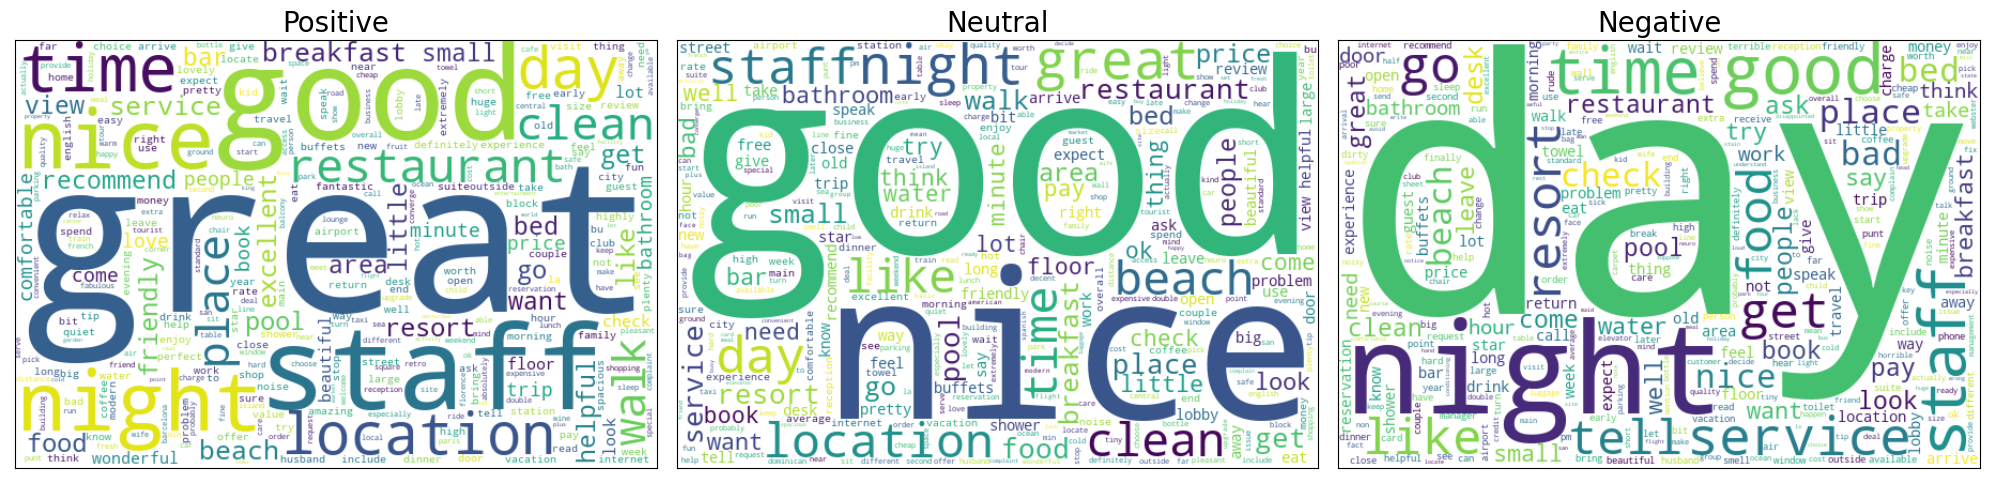

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,40))
for i in range(3):
    plt.subplot(1,3,i+1)    

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=300, contour_width=3,contour_color='steelblue', width=600, 
    height=400, scale=1, stopwords=["hotel","room","stay"], max_font_size=400, collocations=False)
    # Generate a word cloud
    wordcloud.generate(list_pos_neut_neg[i])
    # Visualize the word cloud
    #wordcloud.to_image()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(list_labels_pos_neut_neg[i], size=20)
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.savefig(fname="img\WordClouds", bbox_inches='tight')
plt.show()

#### LDA

In [304]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [305]:
PreProcess_Reviews_With_SpellCheck_tk = [token.split() for token in data['PreProcess_Reviews_With_SpellCheck']]

In [306]:
# LDA applied in labs 
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim_models
import importlib
from imp import reload

# Create a dictionary representation of the documents.
dictionary = Dictionary(PreProcess_Reviews_With_SpellCheck_tk)

corpus = [dictionary.doc2bow(doc) for doc in PreProcess_Reviews_With_SpellCheck_tk]

# Set training parameters.
num_topics = 10

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    random_state=12345
)

In [307]:
for topic in model.show_topics():
    print('')
    print('Topic',topic[0]+1,':',topic[1])



Topic 1 : 0.017*"beach" + 0.017*"resort" + 0.013*"good" + 0.012*"food" + 0.012*"day" + 0.011*"pool" + 0.011*"time" + 0.009*"go" + 0.009*"great" + 0.008*"people"

Topic 2 : 0.024*"great" + 0.019*"service" + 0.016*"good" + 0.013*"restaurant" + 0.011*"night" + 0.010*"staff" + 0.009*"view" + 0.009*"location" + 0.009*"walk" + 0.008*"nice"

Topic 3 : 0.013*"check" + 0.011*"tell" + 0.011*"staff" + 0.010*"service" + 0.010*"book" + 0.009*"ask" + 0.009*"desk" + 0.009*"night" + 0.009*"day" + 0.008*"say"

Topic 4 : 0.013*"pool" + 0.013*"great" + 0.012*"good" + 0.011*"nice" + 0.009*"time" + 0.008*"staff" + 0.008*"restaurant" + 0.008*"night" + 0.007*"go" + 0.007*"day"

Topic 5 : 0.012*"night" + 0.012*"staff" + 0.012*"great" + 0.011*"good" + 0.011*"walk" + 0.010*"clean" + 0.010*"barcelona" + 0.009*"nice" + 0.009*"location" + 0.009*"small"

Topic 6 : 0.040*"position" + 0.024*"lit" + 0.009*"maids" + 0.009*"soften" + 0.008*"stink" + 0.008*"star" + 0.007*"formal" + 0.007*"commitment" + 0.007*"vanilla" +

#### Intertopic Distance Map (IDM)

In [308]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.061969  0.128194       1        1  25.924077
1     -0.047788 -0.042602       2        1   7.803125
2     -0.020678  0.118243       3        1  11.165014
3     -0.048023  0.058747       4        1  10.456222
4     -0.041409 -0.064965       5        1   8.355270
5      0.322724 -0.002734       6        1   0.215906
6     -0.038547  0.010991       7        1  16.829353
7     -0.063628 -0.106164       8        1  12.110027
8     -0.029207 -0.101839       9        1   5.162332
9      0.028524  0.002129      10        1   1.978674, topic_info=           Term          Freq         Total Category  logprob  loglift
24        great  21995.000000  21995.000000  Default  30.0000  30.0000
4061      beach   9826.000000   9826.000000  Default  29.0000  29.0000
4022     resort   8402.000000   8402.000000  Default  28.0000  28.0000
32     location  10678.000000  10678.000000  Default  27.0000  27.0000
979        pool   9090.000000   9090.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
30         like    120.589197   9456.881872  Topic10  -5.6909  -0.4394
330   wonderful    112.430639   3803.101671  Topic10  -5.7610   0.4015
808        tour    108.056118   2062.044699  Topic10  -5.8007   0.9739
41        night    118.876843  14216.414082  Topic10  -5.7052  -0.8613
326        time    110.922381  12591.561766  Topic10  -5.7745  -0.8092

[849 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
12673      8  0.985424  academic
5871       2  0.028440   academy
5871       9  0.952737   academy
5871      10  0.014220   academy
4412       1  0.026904   account
...      ...       ...       ...
2964       6  0.001691      york
2964       7  0.011834      york
2964       8  0.169052      york
2964       9  0.632254      york
2964      10  0.003381      york

[3095 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Conclusion on LDA:

Comparing LDA approach on data pre-processed with spell checking with the first analysis, LDA on data without spell checking, it doesn't seem to exist much difference between both implementations.
As in the first analysis, there are some topics that make sense and can be related to:

* Topic 2,7,8,9: "Top Hotels/Comfortable Hotels"
* Topic 1,4: “Resort Hotels”
* Topic 3: Maybe some “Complaints” 
* Topic 9: “Nice Hotels in San Juan”

Also, as in the first analysis, there is also a strange topic that doesn’t seem to mean anything (topic 6).
This reinforces once more the fact that, overall, the output of the model is not very decisive, and sometimes quite confusing


#### BERTopic

In [155]:
from umap import UMAP
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(ngram_range=(1,3))

umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.2, metric='cosine', random_state=42)

topic_model = BERTopic(vectorizer_model=vectorizer_model,
                        language='english',
                        umap_model=umap_model)

In [233]:
text= data['PreProcess_Reviews_With_SpellCheck']
topics, probs = topic_model.fit_transform(text)

2023-01-13 23:39:08,495 - BERTopic - Transformed documents to Embeddings
2023-01-13 23:39:28,815 - BERTopic - Reduced dimensionality
2023-01-13 23:39:34,524 - BERTopic - Clustered reduced embeddings


In [234]:
topic_model.get_topic_info()

Topic  Count                                               Name
0      -1  10664                          -1_great_good_staff_night
1       0   1705                            0_beach_resort_day_pool
2       1    845                    1_florence_italy_breakfast_walk
3       2    696                    2_amsterdam_location_canal_trap
4       3    677                       3_paris_retro_location_staff
..    ...    ...                                                ...
78     77     12                 77_breakfast_selection_retro_floor
79     78     10         78_chinatown_location_convenient_long bare
80     79     10                   79_bad_complaint_review_distract
81     80     10  80_pool_extremely expensive_newly refurbish_po...
82     81     10     81_hilton_hilton frankfort_frankfort_executive

[83 rows x 3 columns]

-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [235]:
topic_model.get_topic(0) # Select the most frequent topic

[('beach', 0.00677042700605967),
 ('resort', 0.00665835285372184),
 ('day', 0.00534608549234183),
 ('pool', 0.0051793517063926185),
 ('food', 0.004786556642794452),
 ('time', 0.00478643160073824),
 ('go', 0.004685604781885852),
 ('good', 0.004679270358444123),
 ('get', 0.0044890570310179515),
 ('people', 0.0043834179874919985)]

Running the same BERTopic model (same hyperparameters and same random state) on data with spell checking it's possible to notice a reduction of topics that are automatically generated from 97 to 83 topics. This might mean that since some words that were misspelled before now are correctly spelled, there’s an aggregation of those words in the initial created topics, discarding the need of creating more topics.

Also, the most frequent topic changed from a more specific topic (Hotels in Italy) to a more general topic “Resort Hotels”.

In [236]:
topic_model.visualize_hierarchy()

In [237]:
topic_model.visualize_topics()

##### Optimize Labels


In [238]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [239]:
tuned_labels = dict()

for topic in topic_model.topic_labels_:
    sequence_to_classify =  " ".join([word for word, _ in topic_model.get_topic(topic)])
    # Our set of potential topic labels
    candidate_labels = ['Good', 'Bad']
    classifier_output=classifier(sequence_to_classify, candidate_labels)
    tuned_labels[topic] = classifier_output["labels"][0]

In [240]:
neg_tuned_labels = dict()
pos_tuned_labels = dict() 

for key,value in tuned_labels.items():
    if value=='Good':
        pos_tuned_labels[key]=value
    if value=='Bad':
        neg_tuned_labels[key]=value

##### What makes hotels good or bad?

In [241]:
topic_model.visualize_barchart(topics= pos_tuned_labels.keys(),title="Good Hotels - Topic Word Scores")

In [242]:
topic_model.visualize_barchart(topics= neg_tuned_labels.keys(),title="Bad Hotels - Topic Word Scores")

Looking at the generated topics on the dataset where spell checking was applied, it’s possible to note almost immediately that a major problem arises: Words that were spell corrected but only made sense in its original form (before spell checking). 
This seems to happen because the spell checker applied uses English as the language and even though the original dataset is indeed in english, there are some words that should maintain it’s original form, such as, public transportation names, street/city area names, hotel names, cities/places names, and possibly others. To illustrate this situation, let’s observe the examples below:

* **Foreign Language:** 
    * By comparing topic 6 with its corresponding topic in the first analysis (topic 10), the word “bahn” (meaning train in german) was wrongly corrected to “barn”. Since the main word of the topic is berlin (capital of Germany), this topic probably corresponds to (Hotels in Berlin) and therefore, it’s not surprising the use of the word “bahn” instead of subway or underground.

    * Topic 3 refers to “Hotels in Paris” and it shows the word “retro” instead of its original word “metro” as in topic 2 (first analysis). It happens that the term “metro” is used mainly in Europe and in the US/UK the term used is subway or underground/tube. Not surprisingly, the same didn’t happen in topic 10 (Hotels in London), where the word “tube” exists.

* **Official Names**: 
    * Street Names: Topic 4 refers to “Hotels in Barcelona”. The word “rambla” refers to a very touristic street in Barcelona, a city in Spain, called “La Rambla”. Therefore, once again, spell checking incorrectly changed the word “rambla” for “rabble”.

    * Hotel Names: In topic 22, the original word “raffle”, that refers a hotel in Singapore called “Raffles Hotel” was changed to ruffle. It’s also important to notice that both pre-processing, due to lemmatization, probably changed the raw word “raffles” to raffle”, meaning that some word incoherency happened from the beginning. 
    
    * Cities/Places: In topic 24, the words referring to Punta Cana, a resort town in the Dominican Republic, were changed to “punt” and “can”. Contrarily to its matching topic in the first analysis that maintained its original form (topic 22).

* **Mistakes**: In topic 31 “shuttle” and ”airport shuttle” (matching topic 33) were corrected to scuttle and airport scuttle. This correction doesn’t make sense at all, since the word “shuttle” exists in the English dictionary, meaning “a form of transport that travels regularly between two places.”



In [210]:
topics_per_class = topic_model.topics_per_class(text, classes=data["Label"] )
topic_model.visualize_topics_per_class(topics_per_class,top_n_topics=105,normalize_frequency=True)

#### BERTopic VS LDA

Analysing BERTopic against LDA it’s evident that LDA performs worst when compared BERTopic. Even though LDA analysis produced some topics with meaning to a certain extent, some were very similar to each other, which didn’t lead to any proper conclusion. In both analysis there was 1 out of 10 topics that didn’t make any sense, containing random words that didn't seem to be connected in any way. Additionally, BERTopic have shown a very interactive and visual way of presenting its results, allowing a smoother analysis.

#### No Spell Checking VS Spell Checking

Comparing the analysis of data without spell checking to data with spell checking, it seems that both BERTopic analysis generated similar topics. Some topics might differ to some degree, and even some that are present in one analysis might be different in the other analysis, but, overall, both produced fine precise and insightful conclusions. 

However, in this research, spell checking didn’t seem to positively impact the quality of the analysis. The running time of the pre-processing on the full dataset (20k Reviews on total) was substantially higher when compared to the pre-processing without spell checking (5h vs 3mn = 100x slower) and the topics generated were very similar, which is to say, not better than the ones generated in the first analysis. At last, there was even an unexpected negative aspect regarding some words that were incorrectly tagged as misspelled and “corrected” to a new word, which resulted in terms out of context inside of topics that, in the analysis without spell checking, were coherent.